This notebook handles the labeling of data from videos of humans performing postural correction exercises.

In [ ]:
# installs the dependencies in jupyter notebook
# this is a workaround in case you have anaconda/miniconda on your system
# and jupyter notebook not running in a conda environment
# because in that case running pip install on your terminal will result in
# dependencies being installed in conda but being unusable in jupyter notebook

# if modules still fail to import in the next block run this block 5-10 times because
#  somehow, it needs to be run multiple times to get over the errors one at a time
import sys
!{sys.executable} -m pip install -r requirements.txt

In [107]:
# import the modules
# the required packages are listed in requirements.txt for easy installation

import imageio

imageio.plugins.ffmpeg.download()

from keras.callbacks import EarlyStopping
import argparse, time, logging, os, math, tqdm
from tqdm import tqdm_notebook as tqdm
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.mobilenetv2 import MobileNetV2
from IPython.display import clear_output
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
import pandas as pd
import gluoncv as gcv
import time
from gluoncv import data
from moviepy.editor import *
from gluoncv.data import mscoco
from gluoncv.model_zoo import get_model
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord
from gluoncv.utils.viz import plot_image, plot_keypoints
from keras.models import Model
from keras.layers import *
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.vgg16 import VGG16
import os

We want to extract a bunch of images from the video file, and then create the models taking the posture model

In [2]:
ctx = mx.cpu()
detector_name = "ssd_512_mobilenet1.0_coco"
# get_model is from gluoncv
detector = get_model(detector_name, pretrained=True, ctx=ctx)

detector.reset_class(classes=['person'], reuse_weights={'person':'person'})

estimator = get_model('simple_pose_resnet18_v1b', pretrained='ccd24037', ctx=ctx)

In [3]:
def find_images(video_path="demo.mp4"):
    # VideoFileClip is from moviepy.editor
    video = VideoFileClip(video_path)
    ## keep 1 image over // x
    nb_images = (video.fps * video.duration) 
    images = []
    for i in tqdm(range(int(nb_images // 10))):
        image = video.get_frame(i)
        images.append(image)
    return np.array(images)

def find_coords(images):
    coords = []
    frames = []
    for image in tqdm(images):
    # Capture frame-by-frame
        frame = image
        frame = mx.nd.array(frame).astype("uint8")
        x, frame = gcv.data.transforms.presets.yolo.transform_test(frame, short=512, max_size=350)
        x.shape, frame.shape
        x = x.as_in_context(ctx)
        class_IDs, scores, bounding_boxs = detector(x)
        pose_input, upscale_bbox = detector_to_simple_pose(frame, class_IDs, scores, bounding_boxs,
                                                               output_shape=(128, 96), ctx=ctx)
        if len(upscale_bbox) > 0:
            predicted_heatmap = estimator(pose_input)
            pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)
            coords.append(pred_coords[0].asnumpy())
            frames.append(frame)
    return np.array(frames), np.array(coords) 

In [4]:
X_img = []
X_coord = []
video_files = [x for x in os.listdir() if ".mp4" in x]

for demo_path in video_files:
    print("Creating the dataset from the video file {}".format(demo_path))
    images = find_images(demo_path)
    print(len(images))
    images, coords = find_coords(images)
    print(len(images), len(coords))
    X_img.append(images), X_coord.append(coords)

Creating the dataset from the video file demo.mp4



77



76 76
Creating the dataset from the video file demo2.mp4



372



372 372
Creating the dataset from the video file demo3.mp4



61



61 61
Creating the dataset from the video file demo4.mp4



116



116 116


In [5]:
for i in range(len(X_img)):
    #same size ratio for each images. Needed for the inputs
    X_img[i] = np.resize(X_img[i], (X_img[i].shape[0], 197, 350, 3))
    print(X_img[i].shape)

(76, 197, 350, 3)
(372, 197, 350, 3)
(61, 197, 350, 3)
(116, 197, 350, 3)


In [6]:
X_img, X_coord = np.concatenate(X_img), np.concatenate(X_coord)
X_img.shape, X_coord.shape

((625, 197, 350, 3), (625, 17, 2))

This image is one example of the projection.
The rectangle is from YOLO.
YOLO (You Only Look Once) is a state-of-the-art real-time object detection system.
The rigid body lines are from PosNet.
PosNet detects posture of humans in an image.


## Data labelisation

Each data is labeled 0, 1 or 2 based on the following criteria: 

- 0 - normal face - face looking forwards in a relaxed manner
- 1 - middle position - chin is pulled into the neck, pushing the skull towards the back
- 2 - back position - face is looking upwards

In [68]:
current = 0
y = []

In [ ]:
labeled = True
print(current)
if not labeled:
    # need to do that for a lot of videos
    for i,frame in enumerate(X_img):
        if i >= current:
            print(" {} % of the images have labels. Continue !".format(int(100 * (i / len(X_img)))))
            print("Reminder guys: 0: normal position, 1: middle position, 2: back position")
            plt.imshow(frame)
            plt.show()
            the_input = input("Classe of this image ?")
            if the_input == '':
                the_input = '0'
            y.append(int(the_input)) # need to put 0 or 1 depending on the images
            clear_output(wait=True)
            current = i
y = np.array(y)
y = pd.get_dummies(y)

In [102]:
X.shape

(625, 17, 2)

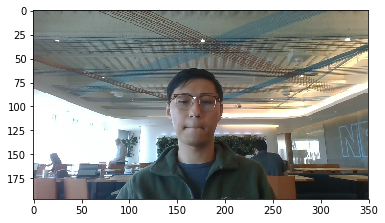

In [106]:
plt.imshow(X_img[-300])
plt.show()

## Model training

X.shape should equal y.shape if you have labeled all the data

In [70]:
X_img.shape, X_coord.shape, y.shape

((625, 197, 350, 3), (625, 17, 2), (625, 3))

In [71]:
X = X_coord

In [72]:
# train_test_split is from sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [73]:
c = {"neutral": 0, "middle": 1, "back": 2}

Use a simple deep neural network to train the model based on the labeled data.
This model is based on the pose data.
We need to compare its accuracy with a normal image model.

In [87]:
tb_pose = TensorBoard("logs/model_pose")
early = EarlyStopping()
def my_model_pose():
    # using keras functions
    pose = Input(shape=(17,2))
    features = BatchNormalization()(pose)
    features = Flatten()(features)
    features = Dropout(0.2)(features)
    features = Dense(2,activation="relu")(features)
    y = Dense(3, activation="softmax")(features)
    model = Model(pose, y)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="Adam")
    model.summary()
    return model

In [89]:
model_pose = my_model_pose()
model_pose.fit(X_train, y_train, verbose=0, callbacks=[tb_pose, early], batch_size=1,validation_data=[X_test, y_test], epochs=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 17, 2)             0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 17, 2)             8         
_________________________________________________________________
flatten_10 (Flatten)         (None, 34)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 34)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 70        
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 9         
Total params: 87
Trainable params: 83
Non-trainable params: 4
_________________________________________________________________


In [90]:
tb_img = TensorBoard("logs/model_img")
early = EarlyStopping()
def my_model_img():
    base_model_img = MobileNetV2(include_top=False)
    base_model_img = MobileNetV2(include_top=False)
    #Only the last layers are trainable
    for layer in base_model_img.layers:
        layer.trainable = False
    x = base_model_img.output
    x = GlobalAveragePooling2D()(x)
    y = Dense(3, activation="softmax")(x)
    model = Model(inputs=base_model_img.input, outputs=y)
    model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
    return model

In [91]:
model_img = my_model_img()

In [92]:
X_img_train, X_img_test, y_train, y_test = train_test_split(X_img, y)

In [96]:
model_img.fit(X_img_train, y_train, callbacks=[tb_img], validation_data=[X_img_test, y_test], batch_size=1, epochs=1000)

Train on 468 samples, validate on 157 samples
Epoch 1/1000
468/468 [==============================] - 30s 63ms/step - loss: 0.3581 - acc: 0.8846 - val_loss: 0.5637 - val_acc: 0.8471
Epoch 2/1000
468/468 [==============================] - 31s 67ms/step - loss: 0.3251 - acc: 0.8739 - val_loss: 0.5999 - val_acc: 0.8471
Epoch 3/1000
468/468 [==============================] - 30s 63ms/step - loss: 0.2967 - acc: 0.8868 - val_loss: 0.8082 - val_acc: 0.4395
Epoch 4/1000
468/468 [==============================] - 30s 64ms/step - loss: 0.3021 - acc: 0.8868 - val_loss: 0.5831 - val_acc: 0.8471
Epoch 5/1000
468/468 [==============================] - 29s 62ms/step - loss: 0.2549 - acc: 0.9038 - val_loss: 0.6960 - val_acc: 0.8471
Epoch 6/1000
468/468 [==============================] - 29s 62ms/step - loss: 0.2316 - acc: 0.9103 - val_loss: 0.9136 - val_acc: 0.4204
Epoch 7/1000
468/468 [==============================] - 29s 62ms/step - loss: 0.2408 - acc: 0.9145 - val_loss: 0.8547 - val_acc: 0.7707
Ep

KeyboardInterrupt: 

In [100]:
np.save("X_img.npy", X_img)
np.save("X_coord.npy", X_coord)
np.save("y.npy", y)

In [ ]:
model_img.save("model_img.h5")

In [ ]:
model_pose.save("model_pose.h5")